<a href="https://colab.research.google.com/github/hypeprogrammer/BigData/blob/main/240712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            1000 non-null   object 
 1   coil_count           1000 non-null   int64  
 2   magnet_strength      1000 non-null   float64
 3   wind_speed           1000 non-null   float64
 4   actual_power_output  1000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 39.2+ KB


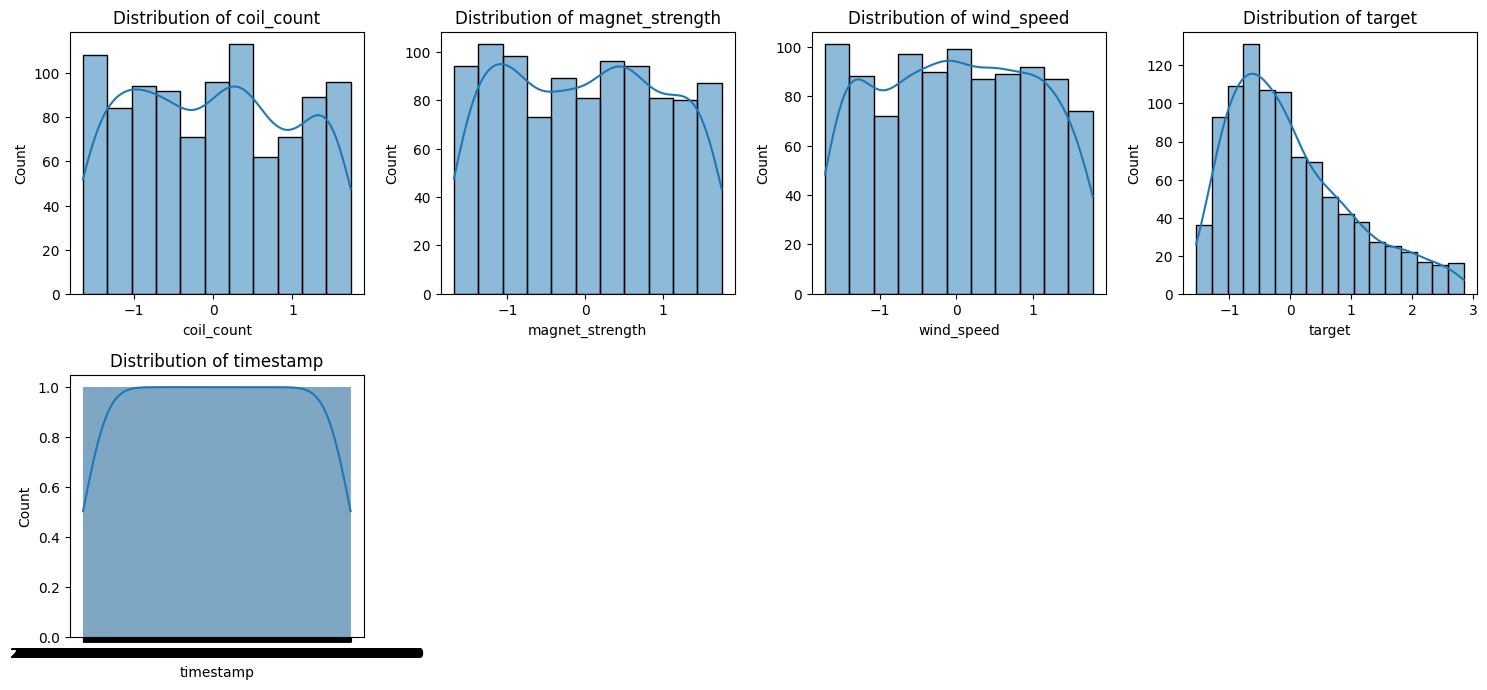

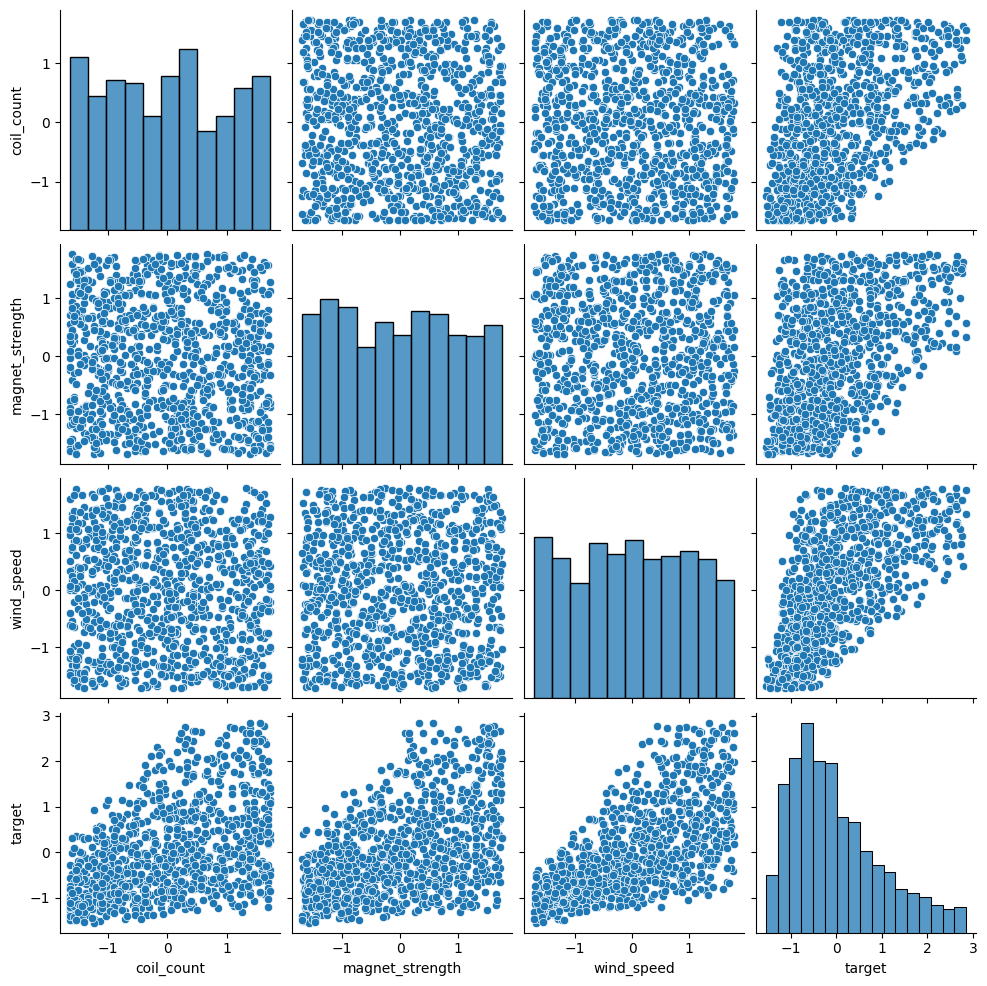

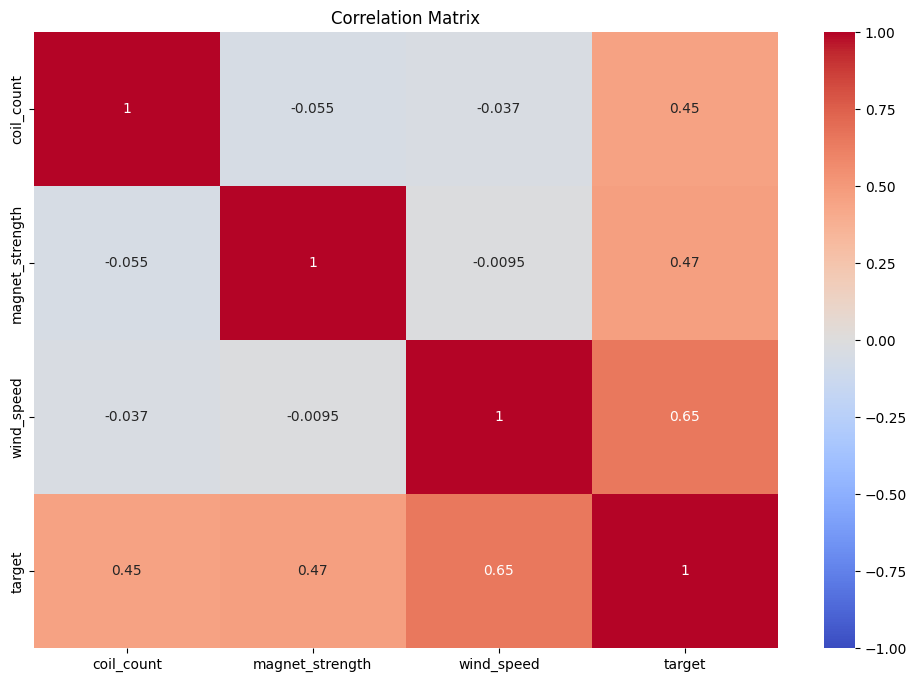

1일차: 데이터 로드 및 요구 사항 분석
None
             timestamp  coil_count  magnet_strength  wind_speed  \
0  2023-01-01 00:00:00         101         1.086841   10.262251   
1  2023-01-01 01:00:00         142         1.245439   12.202728   
2  2023-01-01 02:00:00          64         0.931660    6.752855   
3  2023-01-01 03:00:00         121         0.627580   23.739156   
4  2023-01-01 04:00:00         110         0.783776   16.076045   

   actual_power_output  
0            11.264971  
1            21.580818  
2             4.026472  
3            18.026855  
4            13.860018  
        coil_count  magnet_strength   wind_speed  actual_power_output
count  1000.000000      1000.000000  1000.000000          1000.000000
mean     99.128000         1.000324    14.988347            14.911117
std      29.573505         0.290494     5.770875             9.007939
min      50.000000         0.504632     5.002694             1.742191
25%      73.000000         0.737138    10.193873             8.260906

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# 1일차: 데이터 로드 및 요구 사항 분석
file_path = './Wind_Turbine_Data.csv'
data = pd.read_csv(file_path)

# 데이터 구조 및 내용 확인
data_info = data.info()
data_head = data.head()
data_description = data.describe()

# 예시로, 마지막 컬럼을 타겟 컬럼으로 사용
target_column = data.columns[-1]
data = data.rename(columns={target_column: 'target'})

# 2일차: 데이터 정제
missing_values = data.isnull().sum()
columns_to_drop = missing_values[missing_values > len(data) * 0.05].index
data_cleaned = data.drop(columns=columns_to_drop)

# 'timestamp' 컬럼을 제외하고 숫자형 컬럼만 선택하여 평균 계산
numeric_columns = data_cleaned.select_dtypes(include=np.number).columns
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].fillna(data_cleaned[numeric_columns].mean())

missing_values_after_cleaning = data_cleaned.isnull().sum()

# 3일차: 데이터 클렌징
# 'timestamp' 컬럼을 제외하고 숫자형 컬럼만 선택하여 quantile 계산
numeric_columns = data_cleaned.select_dtypes(include=np.number).columns
Q1 = data_cleaned[numeric_columns].quantile(0.25)
Q3 = data_cleaned[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# 이상치 제거는 숫자형 컬럼에 대해서만 수행
data_cleaned_no_outliers = data_cleaned[~((data_cleaned[numeric_columns] < (Q1 - 1.5 * IQR)) | (data_cleaned[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# 데이터 스케일링
# 'timestamp' 컬럼을 제외하고 스케일링 적용
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned_no_outliers.drop(columns=['timestamp']))
data_final = pd.DataFrame(data_scaled, columns=data_cleaned_no_outliers.drop(columns=['timestamp']).columns)
data_final['timestamp'] = data_cleaned_no_outliers['timestamp']  # 'timestamp' 컬럼 다시 추가

# 4일차: 데이터 시각화 및 EDA
plt.figure(figsize=(15, 10))
for i, column in enumerate(data_final.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(data_final[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

sns.pairplot(data_final)
plt.show()

# 'timestamp' 컬럼 제외하고 상관관계 행렬 계산
correlation_matrix = data_final.drop(columns=['timestamp']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 5일차: 모델 선택 및 개발
X = data_final.drop(columns=['target', 'timestamp'])  # 'timestamp' 컬럼 제외
y = data_final['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

evaluation_results = {
    'mse_train': mse_train,
    'r2_train': r2_train,
    'mse_test': mse_test,
    'r2_test': r2_test
}

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("1일차: 데이터 로드 및 요구 사항 분석")
print(data_info)
print(data_head)
print(data_description)
print("\n2일차: 데이터 정제")
print("Columns to drop due to high missing values:", columns_to_drop)
print("Missing values after cleaning:", missing_values_after_cleaning)
print("\n3일차: 데이터 클렌징")
print(data_cleaned_no_outliers.describe())
print("\n4일차: 데이터 시각화 및 EDA")
print("Correlation matrix:\n", correlation_matrix)
print("\n5일차: 모델 선택 및 개발")
print("Evaluation results:", evaluation_results)
print("Best parameters from Grid Search:", best_params)
print("Best score from Grid Search:", best_score)
